# Тестовое задание на позицию Data Analyst - Бурый Артём
<div style="text-align: right"><a target="_blank" href="https://drive.google.com/file/d/14Hl1gFeVGPm1ChDI1HlNQB4Tz6bFH1Qd/view?usp=sharing">Резюме</a></div>

## SQL блок (написан под PostgreSQL)
Для начала создадим необходимые для задания таблицы

```sql
create table registration ("user_id" int not null primary key,
							"timestamp" timestamp,
							"source" varchar,
							"cost" int);
						
insert into registration ("user_id", "timestamp", "source", "cost") 
	values (generate_series(1, 1000), 
		timestamp '2023-01-01 00:00:00' + random() * interval '300 days',
		(array['c1', 'c2', 'c3'])[floor(random() * 3 + 1)],
		floor(random() * 100 + 1));
	
create table payments ("user_id" int not null,
							"payment_id" int not null primary key,
							"payment_ts" timestamp,
							"payment_usd" int,
							constraint fk_user
						      foreign key(user_id) 
							  	references registration(user_id));

insert into payments ("user_id", "payment_id", "payment_ts", "payment_usd")
select t.user_id,
	t.payment_id,
	t.timestamp,
	t.payment_usd 
from (select floor(random()*1000 + 1) as "user_id",
	generate_series(1,2000) as "payment_id",
	timestamp '2023-01-01 00:00:00' + random() * interval '600 days' as "timestamp",
	floor(random()*100 + 1) as "payment_usd"
) as t
left join registration r on r.user_id = t.user_id
where r.timestamp < t.timestamp
	and t.timestamp < now();
```

1. Конверсію з реєстрації в оплату за місяцями реєстрації ( Інвестори прийшли -і терміново хочуть знати динаміку цього показнику через загальну рецесію )
```sql
select to_char(r."timestamp", 'YYYY-MM') as "year-month",
	1.0 * sum(case when r.user_id in (select distinct p.user_id from payments p) then 1 else 0 end) / nullif(count(*),0) as "conversion"
from registration r 
group by to_char(r."timestamp", 'YYYY-MM')
order by to_char(r."timestamp", 'YYYY-MM');
```
2. Середній LTV клієнтів 180 днів за сорсами трафіку. LTV вважати суму всіх платежів. (Маркетологам дуже треба це знання для оптимізації трафіку в рамках ROMI + з якої ставки стартувати в нових партнерках)
Здесь я честно не очень понимаю, что за 180 дней. Это предполагаемая продолжительность "жизни" клиентов? Или мне надо проанализировать только клиентов, которые пришли в какой-то промежуток времени в 180 дней? 
```sql
TBA
```
3. Типовий час між 1ою та 2ою оплатою ( Хочеться дивитися на конверсію з 1ої в 2гу оплату у звіті -але останні дні завжди мають нижчі показники -то ж треба зафіксувати період , в який дивимося  )
```sql
with t as (
select p.user_id,
	row_number () OVER (partition by p.user_id	order by p.payment_ts),
	lead(p.payment_ts, 1) OVER (partition by p.user_id	order by p.payment_ts) - p.payment_ts as time_delta
from payments p
)
select avg(t.time_delta) as average_time_delta
from t
where t.row_number = 1
	and t.time_delta is not null;
```
На созданных таблицах данные запросы отрабатывали без ошибок и выдавали адекватные результаты.
## Data Exploration блок
### Подготовка данных

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
url = "https://docs.google.com/spreadsheets/d/1rLg0ZvTIAESz2R6zEc3AGjL1sdRMj4Zl-55PtukyTl0/export?format=xlsx"
df = pd.read_excel(url, sheet_name="Exploration data")
df

,user_id,registration_date,is_test_user,is_high_value_customer,paid_7d,paid_8_14d,payments_7d,payments_8_14d,first_payment_date,last_payment_date,...,open_8_14d,click_8_14d,page_visits_7d,page_visits_8_14d,logins_7d,logins_8_14d,first_session_duration_minutes,user_first_os,score1,score2
0,442950.0,2022-03-06 08:39:10.000000,0.0,0.0,0.000000,0.0,0.0,0.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,11.0,Android,6.0,17.0
1,957150.0,2022-06-17 03:17:09.000000,0.0,1.0,8.102620,0.0,2.0,0.0,2022-06-17 05:41:12.000000,2022-06-18 21:52:55.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,9.0,Android,48.0,17.0
2,1112646.0,2022-07-16 20:13:52.000000,0.0,0.0,10.017636,0.0,2.0,0.0,2022-07-21 14:36:35.000000,2022-07-21 16:43:25.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,7.0,Android,10.0,63.0
3,1294040.0,2022-08-14 15:29:50.000000,0.0,0.0,2.283319,0.0,1.0,0.0,2022-08-16 10:39:04.000000,2022-08-16 10:39:04.000000,...,13.0,4.0,0.0,0.0,0.0,0.0,4.0,iOS,76.0,58.0
4,1414332.0,2022-09-06 17:41:25.000000,0.0,0.0,8.333930,0.0,1.0,0.0,2022-09-06 17:45:37.000000,2022-09-06 17:45:37.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,10.0,Android,44.0,23.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,1071006.0,2022-07-10 03:12:41.000000,0.0,0.0,4.373870,0.0,1.0,0.0,2022-07-10 03:18:20.000000,2022-07-10 03:18:20.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,15.0,iOS,72.0,9.0
4996,847845.0,2022-05-22 01:53:13.000000,0.0,0.0,0.000000,0.0,0.0,0.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,13.0,Android,94.0,7.0
4997,153552.0,2022-01-24 07:49:51.000000,0.0,0.0,0.000000,0.0,0.0,0.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,5.0,Android,27.0,28.0
4998,171984.0,2022-01-26 14:02:40.000000,0.0,0.0,17.891515,0.0,1.0,0.0,2022-01-28 11:54:23.000000,2022-01-28 11:54:23.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,Android,2.0,18.0


Приведем к правильным типам данных

In [16]:
df[['registration_date','first_payment_date', 'last_payment_date']] = df[['registration_date','first_payment_date', 'last_payment_date']].astype('datetime64[ns]')
df[['user_id', 'is_test_user', 'is_high_value_customer', 'payments_7d',
       'payments_8_14d', 'sent_7d',
       'open_7d', 'click_7d', 'sent_8_14d', 'open_8_14d', 'click_8_14d',
       'page_visits_7d', 'page_visits_8_14d', 'logins_7d', 'logins_8_14d',
       'first_session_duration_minutes', 'score1', 'score2']] = df[['user_id', 'is_test_user', 'is_high_value_customer', 'payments_7d',
       'payments_8_14d', 'sent_7d', 'open_7d', 'click_7d', 'sent_8_14d', 'open_8_14d', 'click_8_14d',
       'page_visits_7d', 'page_visits_8_14d', 'logins_7d', 'logins_8_14d',
       'first_session_duration_minutes', 'score1', 'score2']].astype('int')

In [18]:
df.describe()

,user_id,is_test_user,is_high_value_customer,paid_7d,paid_8_14d,payments_7d,payments_8_14d,sent_7d,open_7d,click_7d,sent_8_14d,open_8_14d,click_8_14d,page_visits_7d,page_visits_8_14d,logins_7d,logins_8_14d,first_session_duration_minutes,score1,score2
count,5.000000e+03,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,1.145787e+06,0.000800,0.090200,6.649573,3.606449,0.97820,0.328600,21.86060,3.658000,1.003600,7.431200,0.986200,0.32860,0.228000,0.127200,0.024600,0.014800,8.033200,49.601600,28.971800
std,6.224597e+05,0.028276,0.286497,10.293110,13.381558,2.04904,1.571597,25.27068,8.240426,2.790402,10.181198,3.044317,1.18832,2.483959,1.050734,0.335883,0.158069,4.286324,29.181912,22.714467
min,1.680000e+02,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,6.255485e+05,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,4.000000,24.000000,12.000000
50%,1.154266e+06,0.000000,0.000000,0.415161,0.000000,1.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,8.000000,49.000000,22.000000
75%,1.657522e+06,0.000000,0.000000,10.331383,0.000000,1.00000,0.000000,49.00000,0.000000,0.000000,20.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,12.000000,75.000000,46.000000
max,2.226636e+06,1.000000,1.000000,76.296803,155.848320,78.00000,41.000000,72.00000,47.000000,20.000000,34.000000,22.000000,12.00000,36.000000,16.000000,6.000000,4.000000,15.000000,99.000000,99.000000


In [31]:
df.isna().sum()

user_id                              0
registration_date                    0
is_test_user                         0
is_high_value_customer               0
paid_7d                              0
paid_8_14d                           0
payments_7d                          0
payments_8_14d                       0
first_payment_date                2179
last_payment_date                 2179
sent_7d                              0
open_7d                              0
click_7d                             0
sent_8_14d                           0
open_8_14d                           0
click_8_14d                          0
page_visits_7d                       0
page_visits_8_14d                    0
logins_7d                            0
logins_8_14d                         0
first_session_duration_minutes       0
user_first_os                        0
score1                               0
score2                               0
dtype: int64

Нигде нет отрицательных значений, необоснованно высоких максимальных тоже нет. Отсутствуют значения только по датам первого и последнего платежа. Посмотрим, есть ли строки, где first/last payment date есть, а last/first нет.

In [24]:
len(df[((df['first_payment_date'].notna()) & (df['last_payment_date'].isna())) |
  ((df['first_payment_date'].isna()) & (df['last_payment_date'].notna()))])

0

Таких строк нет. Теперь соотнесем оплаты, платежи и даты друг с другом

In [35]:
len(df[~(((df['paid_7d']!=0) & (df['payments_7d']!=0) & (df['first_payment_date'].notna())) |
  ((df['paid_8_14d']!=0) & (df['payments_8_14d']!=0) & (df['first_payment_date'].notna())) |
  ((df['paid_7d']==0) & (df['payments_7d']==0) & (df['paid_8_14d']==0) & (df['payments_8_14d']==0) & (df['first_payment_date'].isna())))])

0

Всё сходится, если есть оплаты, то есть и даты первого/последнего платежа, если оплат нет, то дат тоже нет. Удалим тестовых пользователей и перейдем к исследованию данных

In [37]:
df = df[df['is_test_user']==0]

### Исследование
Сначала построим boxplot в зависимости от is_high_value_customer от каждого параметра. Строим без выбросов, чтобы нагляднее видеть все квартили

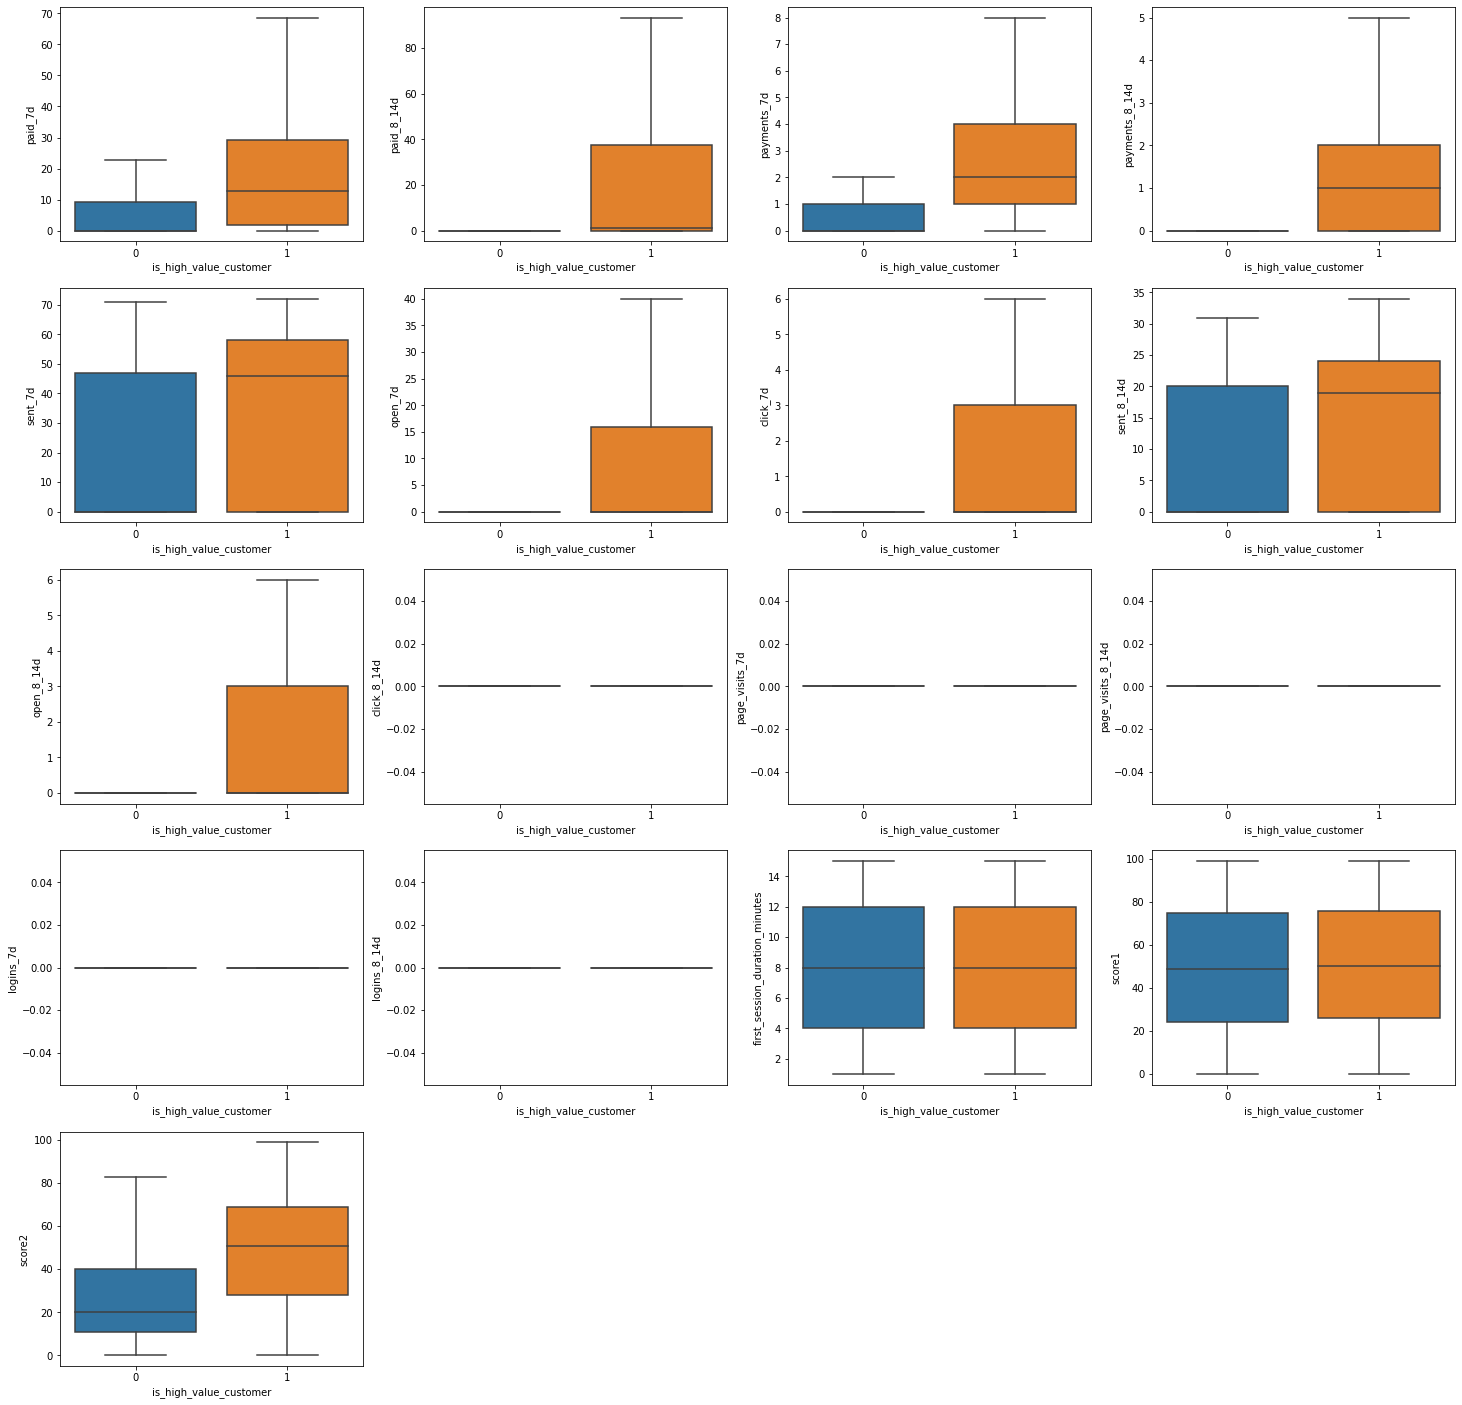

In [64]:
plot_df = df[['is_high_value_customer', 'paid_7d', 'paid_8_14d', 'payments_7d', 'payments_8_14d', 'sent_7d',
       'open_7d', 'click_7d', 'sent_8_14d', 'open_8_14d', 'click_8_14d',
       'page_visits_7d', 'page_visits_8_14d', 'logins_7d', 'logins_8_14d',
       'first_session_duration_minutes', 'score1', 'score2']]
n_rows=5
n_cols=4
# Create the subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(25, 25))

for i, column in enumerate(plot_df.columns[1:]):
    sns.boxplot(data=plot_df, x="is_high_value_customer", y=column,ax=axes[i//n_cols,i%n_cols], showfliers=False)
[fig.delaxes(ax) for ax in axes.flatten() if not ax.has_data()]
plt.show()

В принципе сразу видно, что 